# Results

This notebook is created to analyse results from simulations using specifically the ensemble learning approach.

## Prerequisites
This notebook will run under the condition that some simulations have been run, e.g.
```
(maxsmi) $ python maxsmi/full_workflow.py --task ESOL --string-encoding smiles --aug-strategy-train augmentation_with_duplication --aug-strategy-test augmentation_with_duplication --aug-nb-train 10 --aug-nb-test 10 --ml-model CONV1D --eval-strategy True
```

Have a look at the [README](https://github.com/t-kimber/maxsmi/blob/main/README.md) page for more details.

In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem

In [2]:
TASK = "ESOL"
STRING_ENCODING = "smiles"
TRAIN_AUGMENTATION = 100
TEST_AUGMENTATION = 100
AUGMENTATION_STRATEGY = "augmentation_without_duplication"
ML_MODEL = "CONV1D"

# Load results

This data represents _only_ the test set (20%) and not the full data (100%). It contains most relevant information.

In [3]:
with open(f"output/{TASK}_{STRING_ENCODING}_{AUGMENTATION_STRATEGY}_{TRAIN_AUGMENTATION}_{TEST_AUGMENTATION}_{ML_MODEL}/results_ensemble_learning.pkl", 'rb') as f: 
    test_data = pickle.load(f)

In [4]:
test_data.head()

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction
181,-8.60,CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1,"[C(C)Oc1ccc(C(C)(C)COCc2cccc(c2)Oc2ccccc2)cc1,...","[C(C)Oc1ccc(C(C)(C)COCc2cccc(c2)Oc2ccccc2)cc1,...",-6.335364,0.432646
277,-0.60,CCS,"[C(S)C, CCS, SCC, C(C)S]","[C(S)C, CCS, SCC, C(C)S]",-0.811274,0.167853
125,-0.60,CC(=O)OCC(COC(C)=O)OC(C)=O,"[CC(=O)OCC(OC(=O)C)COC(=O)C, O=C(OCC(COC(=O)C)...","[CC(=O)OCC(OC(=O)C)COC(=O)C, O=C(OCC(COC(=O)C)...",-0.887806,0.308910
937,-0.67,CCC(C)C(C)=O,"[C(C(C)CC)(=O)C, CC(C(=O)C)CC, CC(C(C)=O)CC, C...","[C(C(C)CC)(=O)C, CC(C(=O)C)CC, CC(C(C)=O)CC, C...",-1.068527,0.296181
444,-5.05,C=CCCCCCCC,"[C(CC)CCCCC=C, C(=C)CCCCCCC, C(CCC=C)CCCC, C(C...","[C(CC)CCCCC=C, C(=C)CCCCCCC, C(CCC=C)CCCC, C(C...",-4.789051,0.156997


# Some statistics

### Distribution of the target

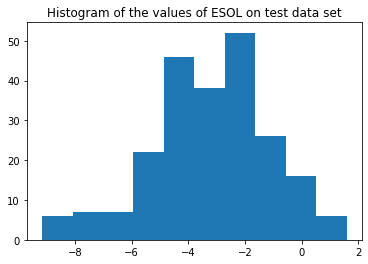

Minimum value: -9.15
Minimum value: 1.58


In [5]:
fig, ax = plt.subplots()
plt.hist(test_data['target'])
ax.set_title(f"Histogram of the values of {TASK} on test data set")
plt.show()
print(f"Minimum value: {test_data['target'].min()}")
print(f"Minimum value: {test_data['target'].max()}")

### Range of standard deviation of prediction

In [6]:
print(f"Minimum: {test_data['std_prediction'].min():.2f} \t \t associated index: {test_data['std_prediction'].idxmin()}")

Minimum: 0.02 	 	 associated index: 1075


In [7]:
print(f"Maximum: {test_data['std_prediction'].max():.2f} \t \t associated index: {test_data['std_prediction'].idxmax()}")

Maximum: 0.57 	 	 associated index: 272


### Look at the molecules

In [8]:
def ensemble_learning_metric(metric="min"):
    """
    Return the rdkit molecule object with `metric` standard deviation.
    
    Parameters
    ----------
    metric : str
        The metric to consider for the standard deviation of the prediction.
    
    Returns
    -------
    tuple
        target, canonical SMILES, random SMILES, RDKit molecule.
    """
    
    if metric == "min":
        index = test_data['std_prediction'].idxmin()
        print(f"Molecule with high confidence prediction (std of) : {test_data['std_prediction'].min():.2f}")
    if metric == "max":
        index = test_data['std_prediction'].idxmax()
        print(f"Molecule with low confidence prediction (std of) : {test_data['std_prediction'].max():.2f}")
        
    canonical_smile = test_data.loc[index]["canonical_smiles"]
    mol = Chem.MolFromSmiles(canonical_smile)
    print("Canonical SMILES: ",  canonical_smile)
    random_smiles = test_data.loc[index]["augmented_smiles"]
    target = test_data.loc[index]["target"]
    print(f"True value: {target:.2f}")
    average_prediction = test_data.loc[index]['average_prediction']
    print(f"Average prediction: {average_prediction:.2f}")
    absolute_error = np.absolute(test_data.loc[index]["target"]-test_data.loc[index]["average_prediction"])
    print(f"Absolute of the averaged error: {absolute_error:.2f}")
    return (target, canonical_smile, random_smiles, mol)

Molecule with high confidence prediction (std of) : 0.02
Canonical SMILES:  ICI
True value: -2.34
Average prediction: -1.92
Absolute of the averaged error: 0.42


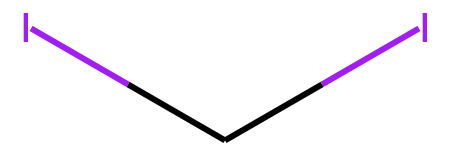

In [9]:
high_confidence_mol = ensemble_learning_metric("min")
high_confidence_mol[3]

Molecule with low confidence prediction (std of) : 0.57
Canonical SMILES:  CC1(C)C(C=C(Br)Br)C1C(=O)OC(C#N)c1cccc(Oc2ccccc2)c1
True value: -8.40
Average prediction: -7.18
Absolute of the averaged error: 1.22


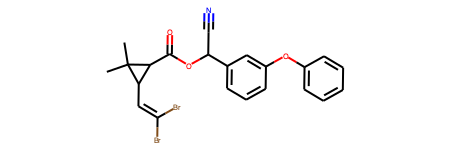

In [10]:
low_confidence_mol = ensemble_learning_metric("max")
low_confidence_mol[3]

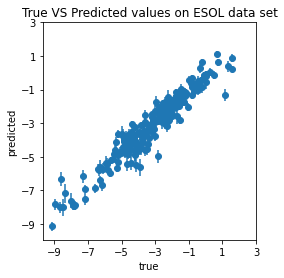

In [11]:
fig, ax = plt.subplots()
x = test_data["target"]
y = test_data["average_prediction"]
err = test_data["std_prediction"]

plt.errorbar(x, y, yerr=err, fmt='o')

ax.set_xticks(np.arange(-9, 4, 2))
ax.set_yticks(np.arange(-9, 4, 2))
ax.set_xlabel("true")
ax.set_ylabel("predicted")
ax.set_aspect("equal", adjustable="box")
ax.set_title(f"True VS Predicted values on {TASK} data set")

plt.show()